## 0 - Librairies

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Masking
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

2025-09-22 14:40:27.880540: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-22 14:40:27.941967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 14:40:29.876315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## 1 - Data Preparation and Visualization

In [5]:
train_df = pd.read_csv("Data/Swissprot_Train_Validation_dataset.csv")
signals_df = pd.read_csv("Data/SortingSignalsSwissprot.csv")
test_df = pd.read_csv("Data/hpa_testset.csv")


In [6]:
print(test_df)

                  sid  Cell membrane  Cytoplasm  Endoplasmic reticulum  \
0     ENSP00000355743              0          0                      0   
1     ENSP00000429628              0          0                      0   
2     ENSP00000266544              0          0                      0   
3     ENSP00000470652              0          0                      0   
4     ENSP00000460751              0          0                      0   
...               ...            ...        ...                    ...   
1712  ENSP00000379284              0          0                      0   
1713  ENSP00000430164              0          1                      0   
1714  ENSP00000414655              0          1                      0   
1715  ENSP00000392070              0          0                      0   
1716  ENSP00000431039              0          0                      0   

      Golgi apparatus  Lysosome/Vacuole  Mitochondrion  Nucleus  Peroxisome  \
0                   0           

In [7]:
# Extract sequences and labels
sequences = train_df["Sequence"].values
labels = train_df.drop(columns=["ACC", "Sequence"]).values  # All columns except ACC and Sequence

Maximum sequence length: 34350


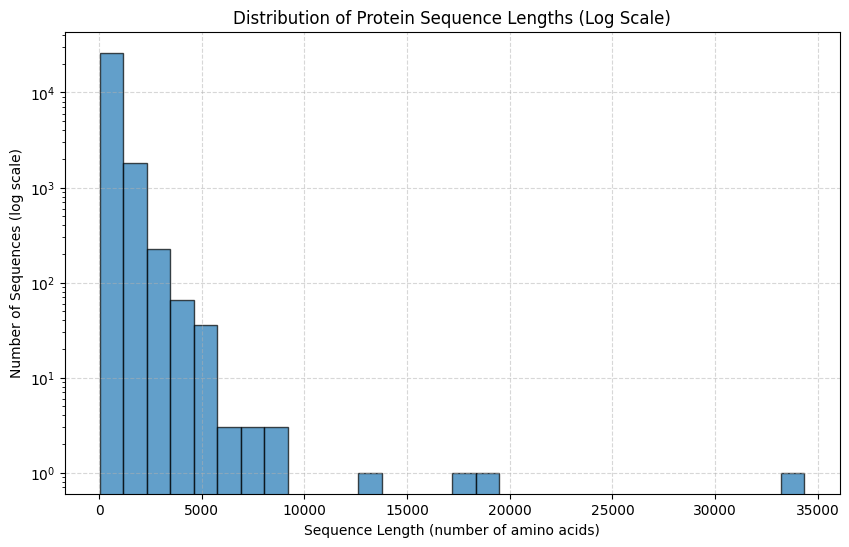

In [8]:
# Find the maximum sequence length
sequence_lengths = [len(seq) for seq in sequences]
max_length = max(sequence_lengths)
print(f"Maximum sequence length: {max_length}")

# Create the histogram with log scale
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=30, edgecolor='black', alpha=0.7, log=True)
plt.title("Distribution of Protein Sequence Lengths (Log Scale)")
plt.xlabel("Sequence Length (number of amino acids)")
plt.ylabel("Number of Sequences (log scale)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Maximum sequence length: 8886


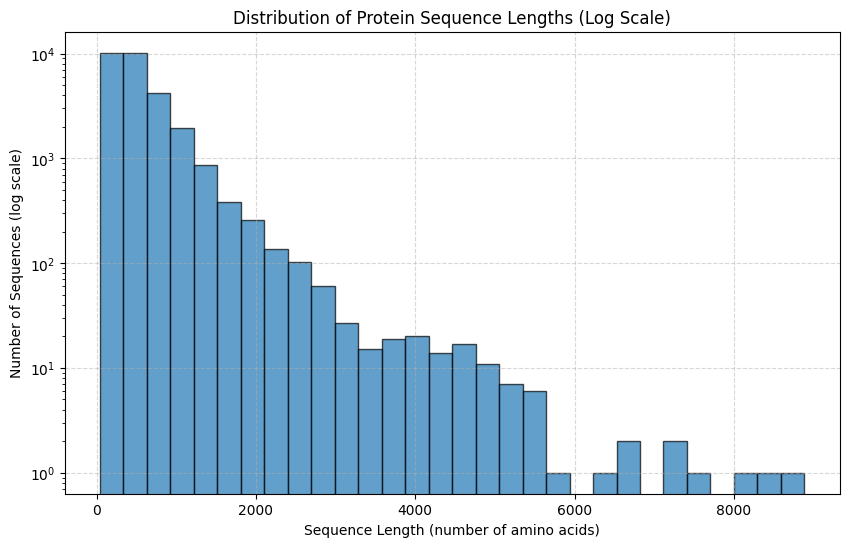

In [ ]:
filter_long_sequences = True

if filter_long_sequences :
    # Filtering sequences with length >= 10000
    filtered_df = train_df[train_df["Sequence"].str.len() <= 10000]

    sequences = filtered_df["Sequence"].values
    labels = filtered_df.drop(columns=["ACC", "Sequence"]).values

    # Find the maximum sequence length
    sequence_lengths = [len(seq) for seq in sequences]
    max_length = max(sequence_lengths)
    print(f"Maximum sequence length: {max_length}")

    # Create the histogram with log scale
    plt.figure(figsize=(10, 6))
    plt.hist(sequence_lengths, bins=30, edgecolor='black', alpha=0.7, log=True)
    plt.title("Distribution of Protein Sequence Lengths (Log Scale)")
    plt.xlabel("Sequence Length (number of amino acids)")
    plt.ylabel("Number of Sequences (log scale)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [ ]:
# List of 20 standard amino acids
amino_acids = sorted(set(''.join(sequences)))

# Function to encode a sequence using one-hot encoding
def encode_sequence(sequence, max_length):
    # Initialize a zero array
    encoded = np.zeros((max_length, len(amino_acids)))
    # Fill the array
    for i, aa in enumerate(sequence[:max_length]):
        if aa in amino_acids:
            encoded[i, amino_acids.index(aa)] = 1
    return encoded

# Apply encoding to all sequences
X = np.array([encode_sequence(seq, max_length) for seq in sequences])
y = labels

## Model Dense

### Parameters

In [ ]:
test_size = 0.2
epochs = 20,
batch_size = 32,
learning_rate = 0.001
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [ ]:
# Define the dense model
model = Sequential([
    Flatten(input_shape=(max_length, len(amino_acids))),  
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='sigmoid')  # 12 neurons for the 12 organelles
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)

# Display model summary
model.summary()

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

## Modele LSTM

### Parameters

In [ ]:
test_size = 0.2
epochs = 20,
batch_size = 32,
learning_rate = 0.001
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [ ]:
model = Sequential([
    # Masquer les timesteps vides (si les séquences ont des longueurs variables)
    Masking(mask_value=0.0, input_shape=(max_length, len(amino_acids))),

    LSTM(128, return_sequences=True),
    Dropout(0.5),

    LSTM(64),
    Dropout(0.5),

    Dense(12, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss,
              metrics=metrics)

# Display model summary
model.summary()

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")